### Testing notebook to prototype exposure custom options

## Getting started
Set working directory to top level of repo to ensure links work correctly:

In [1]:
cd ../..

/home/jovyan/dea_intertidal/dea-intertidal


Install additional packages directly from the requirements file

In [2]:
pip install -r requirements.in --quiet

Note: you may need to restart the kernel to use updated packages.


## Load packages

In [3]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datacube
from datacube.utils.geometry import Geometry

from intertidal.utils import (
    load_config,
    round_date_strings,
    export_intertidal_rasters,
    intertidal_hillshade,
)
from intertidal.elevation import load_data, load_topobathy, elevation
from intertidal.extents import extents
from intertidal.exposure import exposure
from intertidal.tidal_bias_offset import bias_offset, tidal_offset_tidelines
from dea_tools.dask import create_local_dask_cluster

## Setup
### Set analysis parameters

In [9]:
# Set study area and config
study_area = "pointstuart"
config_path = "configs/dea_intertidal_config_development.yaml"
# study_area = '844'
# config_path='configs/dea_intertidal_config.yaml'

# Intertidal Elevation variables
start_date = "2019"  # Start date for analysis
end_date = "2021"  # End date for analysis
resolution = 100  # Spatial resolution used for output files
crs = "EPSG:3577"  # Coordinate Reference System (CRS) to use for output files
ndwi_thresh = 0.1  # Threshold used to identify dry/wet transition when calculating elevation
include_s2 = True  # Include Sentinel-2 data in the analysis?
include_ls = True  # Include Landsat data in the analysis?
filter_gqa = False  # Filter to remove poorly georeferenced scenes?
tide_model = "FES2014"  # Tide model to use in analysis
tide_model_dir = "/gdata1/data/tide_models"#"/var/share/tide_models"  # Directory containing tide model files
# tide_model = ["FES2014", "FES2012", "TPXO9-atlas-v5"]
# tide_model_dir = "/gdata1/data/tide_models_clipped"

# Exposure variables
modelled_freq = "3h"  # Frequency to run tidal model e.g '30min' or '1h'

# Generate range of times covering entire period of satellite record for exposure and bias/offset calculation
all_timerange = pd.date_range(
    start=round_date_strings(start_date, round_type="start"),
    end=round_date_strings(end_date, round_type="end"),
    freq=modelled_freq,
)

#### *Optional: override study area selection using interactive map*

In [5]:
# from odc.ui import select_on_a_map
# from ipyleaflet import basemaps, basemap_to_tiles

# # Plot interactive map to select area
# basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
# geom = select_on_a_map(height='600px',
#                        layers=(basemap,),
#                        center=(-26, 135),
#                        zoom=4)
# study_area = geom

## Intertidal workflow
#### Load data

In [6]:
# Connect to datacube
dc = datacube.Datacube(app="Intertidal_workflow")

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

satellite_ds = load_data(
    dc=dc,
    study_area=study_area,
    time_range=(start_date, end_date),
    resolution=resolution,
    crs=crs,
    s2_prod="s2_nbart_ndwi" if include_s2 else None,
    ls_prod="ls_nbart_ndwi" if include_ls else None,
    config_path=config_path,
    filter_gqa=filter_gqa)[["ndwi"]]

# Load data and close dask client
satellite_ds.load()
client.close()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/claire.phillips@ga.gov.au/proxy/8787/status,
Dashboard: /user/claire.phillips@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 31,Total memory: 237.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37231,Workers: 1
Dashboard: /user/claire.phillips@ga.gov.au/proxy/8787/status,Total threads: 31
Started: Just now,Total memory: 237.21 GiB
Comm: tcp://127.0.0.1:45337,Total threads: 31
Dashboard: /user/claire.phillips@ga.gov.au/proxy/38025/status,Memory: 237.21 GiB
Nanny: tcp://127.0.0.1:41425,


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


### Load optional topobathy mask
Loads a topo-bathymetric DEM for the extents of the loaded satellite data.
This is used as a coarse mask to constrain the analysis to the coastal zone, improving run time and reducing clear false positives over deep water or elevated land.

In [7]:
# Load data from GA's Australian Bathymetry and Topography Grid 2009
topobathy_ds = load_topobathy(
    dc, satellite_ds, product="ga_multi_ausbath_0", resampling="bilinear"
)

### Intertidal elevation
To run without the topobathy DEM mask, comment out `valid_mask=...`.

In [10]:
# Model elevation for each pixel
ds, ds_aux, tide_m = elevation(
    satellite_ds,
    valid_mask=topobathy_ds.height_depth > -20,
    tide_model=tide_model,
    tide_model_dir=tide_model_dir,
    config_path=config_path,
)

2023-07-14 06:29:09 INFO Modelling tide heights for each pixel
INFO:DEA Intertidal:Modelling tide heights for each pixel


Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides with FES2014
Reprojecting tides into original array


100%|██████████| 328/328 [00:00<00:00, 1507.20it/s]
2023-07-14 06:30:09 INFO Masking nodata and adding tide heights to satellite data array
INFO:DEA Intertidal:Masking nodata and adding tide heights to satellite data array
2023-07-14 06:30:09 INFO Flattening satellite data array and filtering to intertidal candidate pixels
INFO:DEA Intertidal:Flattening satellite data array and filtering to intertidal candidate pixels
2023-07-14 06:30:09 INFO Applying valid data mask to constrain study area
INFO:DEA Intertidal:Applying valid data mask to constrain study area
2023-07-14 06:30:09 INFO Running per-pixel rolling median
INFO:DEA Intertidal:Running per-pixel rolling median


Reducing analysed pixels from 759 to 483 (63.64%)


100%|██████████| 114/114 [00:00<00:00, 434.55it/s]
2023-07-14 06:30:10 INFO Modelling intertidal elevation
INFO:DEA Intertidal:Modelling intertidal elevation
2023-07-14 06:30:10 INFO Modelling intertidal uncertainty
INFO:DEA Intertidal:Modelling intertidal uncertainty
2023-07-14 06:30:10 INFO Unflattening data back to its original spatial dimensions
INFO:DEA Intertidal:Unflattening data back to its original spatial dimensions
2023-07-14 06:30:10 INFO Successfully completed intertidal elevation modelling
INFO:DEA Intertidal:Successfully completed intertidal elevation modelling


### Intertidal extents

In [11]:
ds['extents'] = extents(ds_aux.ndwi_wet_freq, ds.elevation, ds_aux.ndwi_tide_corr)

### Intertidal exposure
Calculate exposure using the script function

In [12]:
ds["exposure"], tide_cq = exposure(
    dem=ds.elevation,
    time_range=all_timerange,
    tide_model=tide_model,
    tide_model_dir=tide_model_dir,
)

Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides with FES2014
Computing tide quantiles
Reprojecting tides into original array


100%|██████████| 101/101 [00:00<00:00, 1230.83it/s]


(array([  759.,  3944.,  8686., 10899., 10626.,  9108., 11385., 12144.,
         6831.,  2277.]),
 array([-3.40335377, -2.76607275, -2.12879174, -1.49151073, -0.85422971,
        -0.2169487 ,  0.42033232,  1.05761333,  1.69489434,  2.33217536,
         2.96945637]),
 <BarContainer object of 10 artists>)

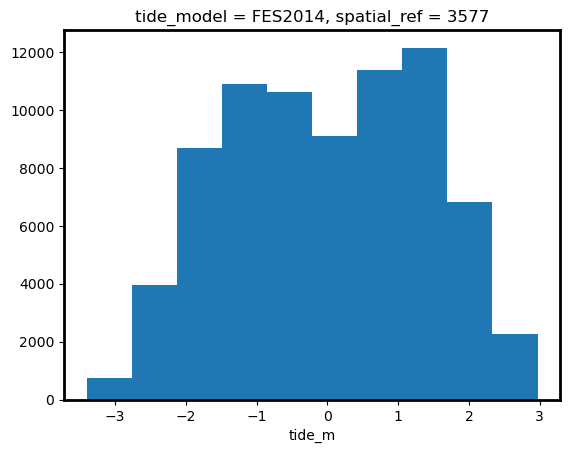

In [32]:
tide_cq.plot()

In [31]:
tide_cq

<xarray.DataArray 'tide_m' (quantile: 101, y: 23, x: 33)>
array([[[-3.37634055, -3.37692342, -3.37750629, ..., -3.3942632 ,
         -3.39487618, -3.39548915],
        [-3.37673483, -3.37732199, -3.37790915, ..., -3.39469375,
         -3.39530464, -3.39591553],
        [-3.37712911, -3.37772056, -3.378312  , ..., -3.39512429,
         -3.39573311, -3.39634192],
        ...,
        [-3.38330868, -3.38397263, -3.38463657, ..., -3.4017773 ,
         -3.40234126, -3.40290522],
        [-3.38353614, -3.38420352, -3.38487091, ..., -3.40200842,
         -3.40256896, -3.40312949],
        [-3.38376359, -3.38443442, -3.38510525, ..., -3.40223955,
         -3.40279666, -3.40335377]],

       [[-2.74970926, -2.74995787, -2.75020648, ..., -2.75781659,
         -2.75810996, -2.75840333],
        [-2.74998174, -2.75023301, -2.75048429, ..., -2.75805019,
         -2.75833804, -2.75862588],
        [-2.75025423, -2.75050816, -2.75076209, ..., -2.7582838 ,
         -2.75856612, -2.75884844],
...
        [ 2.52278528,  2.52333994,  2.5238946 , ...,  2.5376999 ,
          2.53813558,  2.53857126],
        [ 2.52291873,  2.52347693,  2.52403512, ...,  2.53785027,
          2.53828334,  2.53871641],
        [ 2.52305217,  2.52361391,  2.52417565, ...,  2.53800065,
          2.5384311 ,  2.53886155]],

       [[ 2.95389972,  2.95432878,  2.95475784, ...,  2.96725706,
          2.96771961,  2.96818216],
        [ 2.95399062,  2.95442052,  2.95485042, ...,  2.96731993,
          2.96777964,  2.96823936],
        [ 2.95408152,  2.95451226,  2.95494301, ...,  2.9673828 ,
          2.96783968,  2.96829656],
        ...,
        [ 2.95573076,  2.95618443,  2.9566381 , ...,  2.96854077,
          2.96893926,  2.96933775],
        [ 2.95582403,  2.95627995,  2.95673588, ...,  2.96860843,
          2.96900275,  2.96939706],
        [ 2.9559173 ,  2.95637548,  2.95683365, ...,  2.96867609,
          2.96906623,  2.96945637]]])
Coordinates:
    tide_model   <U7 'FES2014'
  * quantile     (quantile) float64 0.0 0.01 0.02 0.03 ... 0.97 0.98 0.99 1.0
    spatial_ref  int32 3577
  * y            (y) float64 -1.286e+06 -1.286e+06 ... -1.288e+06 -1.288e+06
  * x            (x) float64 -1.405e+04 -1.395e+04 ... -1.095e+04 -1.085e+04